In [1]:
#importing libraries and functions
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.interpolate import interp1d
import csv
import matplotlib.gridspec as gridspec

In [2]:
#getting data from pysense csv file
#data comes in 4 columns: temperature, humidity, luminosity, and number of seconds since system startup
#data recorded every 5 minutes

results = []
with open("June05-06RoomData\cleanMachine5DataJune05.csv") as csvfile:#opening file
    reader = csv.reader(csvfile)
    for row in reader:
        results.append(row)
#results is now a 2d array of strings

results = np.array(results[1:])#removing header row

#casting input into floats
data = []
for r in results:
    arr = []
    for c in r:
        arr.append(float(c))
    data.append(arr)

data = np.array(data).T#transposing to correct shape
time = data[3,:]

In [3]:
#getting online weather data from a csv file
#data comes in 3 columns: timestamp, temperature, humidity
#data given once every hour

weatherInput = []
with open("June05-06RoomData\cleanedOnlineWeatherDataJune05-06.csv") as csvfile:#opening file
    reader = csv.reader(csvfile)
    for row in reader:
        weatherInput.append(row)
#results is now a 2d array of strings

weatherInput = np.array(weatherInput[1:])#removing header row

#asting input into floats
weatherData = []
for r in weatherInput:
    arr = []
    for c in r:
        arr.append(float(c))
    weatherData.append(arr)
    
weatherData = np.array(weatherData).T#transposing to corect shape

#removing extra numbers from timestamp
for i in range(len(weatherData[0])):
    weatherData[0,i] = weatherData[0,i]%100
#timestamps now only show the hour of data recording

In [5]:
#interpolating online data to get values for every 5 minutes 
x = weatherData[0]
temp = weatherData[1]
humid = weatherData[2]

#cubic 1-dimensional data interpolation functions:
tempInterpFunc = interp1d(x, temp, kind='cubic')
humidInterpFunc = interp1d(x, humid, kind='cubic')

xnew = np.linspace(13, 23, num=121, endpoint=False)
interpTempData = tempInterpFunc(xnew)
interpHumidData = humidInterpFunc(xnew)
#now we have the same number of data points for online data and pysense data

In [23]:
#inputs to the system: external weather (outside temperature and humidity, plus luminosity)
sys_in = np.concatenate([[interpTempData], [interpHumidData], [data[2]]], 0)

#states of the system: temperature and humidity gathered by pysense
sys_out = np.concatenate([[data[0]], [data[1]]], 0)

print(sys_in.shape)
#3 rows, one for each input to the system, 121 timesteps long
print(sys_out.shape)
#2 rows, one for each element in the sytem state, 121 timesteps long

(3, 121)
(2, 121)


In [26]:
na = 1  # Number of state timesteps looking back
nb = 1 # Number of input timesteps looking back (usually na=nb)
ny = 2  # Number of outputs (room temp and room humidity)
nu = 3  # Number of inputs (external temp, external humidity, pysense luminosity)

In [27]:
#ARX Model: Y=A@X

#constructing X matrix:
#first 2 rows are temperature and humidity of the room for each timestep
#following rows are temp and humidity for 1, 2, and 3 timesteps in the past

X = np.array([sys_in[0]])#initializing X to have the correct shape
#this first row will be removed after further data is appended

    
for k in range(na):#iterating over na number of previous timesteps:
    
    X = np.concatenate([ X, np.roll(sys_out,axis=1,shift=k) ]) #appending state data for each timestep
        
X = X[1:,:] #removing the first row used for initialization

#following rows of states are rows of inputs (external temp, humidity, and luminosity) for each timestep

for k in range(nb):#iterating over nb number of previous timesteps
    X = np.concatenate([ X, np.roll(sys_in,axis=1,shift=k) ]) #appending input data for each previous timestamp

X = X[:, (max(na,nb)-1):-1]#trimming data from the front and end of the array so timesteps line up



print(X.shape)

(5, 120)


In [28]:
#constructing Y matrix:
#room states at each timestep - same as first 2 rows in X matrix

Y = sys_out[:,max(na,nb):]


print(np.shape(Y))

(2, 120)


In [29]:
#using linear algebra to solve for the A matrix in Y=A@X

A = np.linalg.inv(X@X.T)@X@Y.T
A = A.T

In [30]:
print(A)
print(A.shape)

[[ 7.35792504e-01 -8.97123323e-02  3.29610440e-01  5.55032034e-02
   4.45751428e-05]
 [ 1.65904196e-01  9.28984662e-01 -1.80124486e-01  5.45859756e-02
  -5.80313372e-05]]
(2, 5)


In [31]:
#seeing error in model's predicted states compared to real values

y = A@X

diff = Y-y

print(np.sum(np.multiply(diff,diff)))

68.7057291907973


In [32]:
#splitting A matrix into 2 parts- A' and B' referring to previous states and previous inputs respectively

#(next timestep state) = A@(previous states) + B@(previous inputs)

A1 = A[:, 0:na*ny]
B1 = A[:, na*ny:]

print(A1.shape, B1.shape)


(2, 2) (2, 3)


In [33]:
#using model to simulate data given inputs alone
newx_k = 0 


k0 = max(na,nb) 
k = k0

#setting initial conditions
x0 = []
for k in range(na):#iterating over timesteps
    for n in range(ny):#iterating over each element in the state
        x0.append(sys_out[n,k0-k-1])
x0 = np.array([x0]).T

x_k = x0 #setting curent state to given initial conditions

y1 = [] #array used to collect simulated temperature data
y2 = [] #array used to collect simulated humidity data

#looping over each timestep from k0 to the end of the data set
for k in range(k0,len(sys_out[0])):
    
    
    #getting inputs at each timestep
    u_k = []
    for i in range(nb):#iterating over previous nb timesteps
        for n in range(nu):#iterating over each element in the inputs
            u_k.append(sys_in[n,k-i])
    u_k = np.array([u_k]).T
    
    #calculating state of next timestep
    newx_k = A1@x_k + B1@u_k
    
    #adding calculated state to state vector and removing old data
    x_k = np.concatenate([newx_k, x_k])[:-ny,:]
    
    #saving calculated states
    y1.append(x_k[0,0])
    y2.append(x_k[1,0])

#final dataset: concatenating calculated data
simulated_states = np.concatenate([[y1],[y2]],axis=0)

simulated_states = simulated_states[:,:-1]#getting rid of last data point so length is correct
print(np.shape(simulated_states))

(2, 119)


In [34]:
timecomparison = time[max(na,nb)+1:] #array of times for plotting
statecomparison = sys_out[:,max(na,nb)+1:] #array of states for plotting
print(np.shape(statecomparison))

(2, 119)


In [35]:
diff = simulated_states-statecomparison #difference of true values and values calculated from model
print(np.sum(np.multiply(diff,diff)))

252.36407119425087


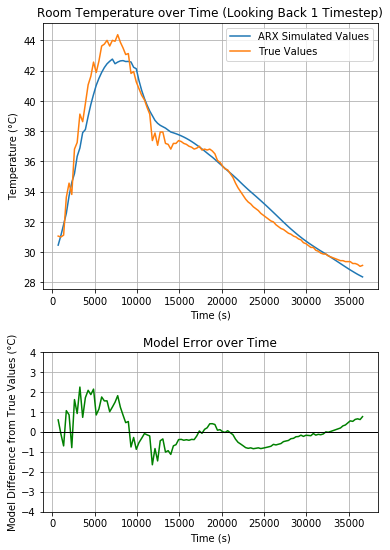

In [38]:
#plotting room temperature - ARX calculated value, true value, and error
timeplot = timecomparison
simplot = simulated_states[0,:]
realplot = statecomparison[0,:]

fig = plt.figure(figsize=(6, 9))
gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios = [5,0.1,3])
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(timeplot, simplot)
ax1.plot(timeplot, realplot)

plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.title('Room Temperature over Time (Looking Back {} Timestep)'.format(na))
plt.legend(['ARX Simulated Values', 'True Values'])
plt.grid(True)

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(timeplot, realplot-simplot, color='g')
ax2.axhline(y=0, color='k', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Model Difference from True Values (°C)')
plt.title('Model Error over Time')
plt.ylim([-4,4])
ax2.set_yticks(range(-4,5))
plt.grid(True)


plt.savefig('ARXTemperature{}timesteps.svg'.format(na))

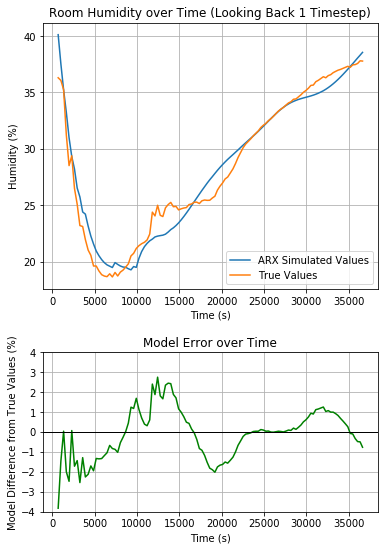

In [39]:
#plotting room humidity - ARX calculated value, true value, and error
timeplot = timecomparison
simplot = simulated_states[1,:]
realplot = statecomparison[1,:]

fig = plt.figure(figsize=(6, 9))
gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios = [5,0.1,3])
ax1 = fig.add_subplot(gs[0, 0])

ax1.plot(timeplot, simplot)
ax1.plot(timeplot, realplot)

plt.xlabel('Time (s)')
plt.ylabel('Humidity (%)')
plt.title('Room Humidity over Time (Looking Back {} Timestep)'.format(na))
plt.legend(['ARX Simulated Values', 'True Values'])
plt.grid(True)

ax2 = fig.add_subplot(gs[2, 0])
ax2.plot(timeplot, realplot-simplot, color='g')
ax2.axhline(y=0, color='k', linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Model Difference from True Values (%)')
plt.title('Model Error over Time')
plt.ylim([-4,4])
ax2.set_yticks(range(-4,5)) 
plt.grid(True)

plt.savefig('ARXHumidity{}timesteps.svg'.format(na))